# <p style="text-align:center;">CART: Classification and Regression Trees</p>

Here, we explore the use of CART (Classification and Regression Trees) for forecasting the direction of variation between Spot and Intraday electricity prices. Both regression and classification approaches are implemented, with a focus on evaluating model performance using a custom weighted accuracy metric.

A first solution we can implement is a CART tree, either using it in regression or classification mode. What matters most is the direction of variation between the Spot price and the Intraday price. We implement both methods here.


# <p style="text-align:center;">Data Import and Required Libraries</p>
In this section, we import the necessary libraries and load the training and test datasets for our analysis.

# Results Summary and Interpretation
- The regression and classification trees provide insight into the direction and magnitude of price differences between Spot and Intraday prices.
- The custom weighted accuracy metric emphasizes correct sign prediction, especially for larger price differences.
- ROC curves and AUC scores help evaluate the discriminative power of the models.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    make_scorer, confusion_matrix, roc_auc_score, roc_curve,
    classification_report
)
from sklearn.tree import plot_tree
from sklearn.preprocessing import label_binarize, LabelEncoder
import holidays

In [61]:
X_train = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\X_train.csv")
X_test = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\X_test.csv")
y_train = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\y_train.csv")
y_random = pd.read_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\data\y_random.csv")
XY_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [36]:
def weighted_accuracy(y_true, y_pred):
    mask = y_true != 0
    y_true_sign = np.sign(y_true[mask])
    y_pred_sign = np.sign(y_pred[mask])
    
    correct = y_true_sign == y_pred_sign
    weights = np.abs(y_true[mask])
    
    return np.sum(weights * correct) / np.sum(weights)

# Custom scorer for model selection
weighted_accuracy_scorer = make_scorer(weighted_accuracy, greater_is_better=True)

In [ ]:
def extract_datetime_features(df, datetime_col="DELIVERY_START_x", country_code="FR"):
    """
    Ajoute des variables temporelles à un DataFrame à partir d'une colonne datetime.

    Paramètres :
    - df : pandas DataFrame
    - datetime_col : nom de la colonne contenant les dates
    - country_code : code pays pour les jours fériés (ex : 'FR' pour France)

    Retour :
    - df enrichi (avec index sur datetime_col)
    """

    # Conversion uniquement si nécessaire
    if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
        df[datetime_col] = pd.to_datetime(df[datetime_col], utc=True)

    # Créer un objet holidays pour les jours fériés
    country_holidays = holidays.CountryHoliday(country_code)

    # Extractions simples
    df["month"] = df[datetime_col].dt.month
    df["day"] = df[datetime_col].dt.day
    df["hour"] = df[datetime_col].dt.hour

    # Jour de la semaine (0=lundi, 6=dimanche)
    df["weekday"] = df[datetime_col].dt.weekday

    # Week-end (1 si samedi ou dimanche)
    df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

    # Heures pleines (par défaut : 7h-23h)
    df["heures_pleines"] = df["hour"].apply(lambda x: 1 if 7 <= x < 23 else 0)

    # Période de la journée : texte ➜ converti en int via LabelEncoder
    def period_of_day(hour):
        if 6 <= hour < 12:
            return "morning"
        elif 12 <= hour < 18:
            return "afternoon"
        elif 18 <= hour < 23:
            return "evening"
        else:
            return "night"

    df["period"] = df["hour"].apply(period_of_day)

    # Encodage de la période en int
    le = LabelEncoder()
    df["period"] = le.fit_transform(df["period"])

    # Jour férié
    df["is_holiday"] = df[datetime_col].dt.date.apply(lambda x: x in country_holidays).astype(int)

    # Heure d'été / heure d'hiver
    try:
        df["is_dst"] = df[datetime_col].dt.dst().notna().astype(int)
    except Exception:
        df["is_dst"] = 0  # fallback si pas de timezone

    # Mettre en index
    df.set_index(datetime_col, inplace=True)

    return df

# <p style="text-align:center;">Regression CART</p>
In this section, we use a Decision Tree Regressor to predict the direction and magnitude of the price difference. The model is optimized using grid search and evaluated with our custom weighted accuracy metric.

In [62]:
X_train1 = extract_datetime_features(X_train, datetime_col="DELIVERY_START")
print(X_train1.head())
# Split the data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_train1, y_train, test_size=0.2, random_state=1)
X_train_reg = X_train_reg.drop("predicted_spot_price", axis=1)
X_test_reg = X_test_reg.drop("predicted_spot_price", axis=1)
X_test_spot = X_test.copy()
X_test_spot = X_test_spot.drop("predicted_spot_price", axis=1)

                           load_forecast  coal_power_available  \
DELIVERY_START                                                   
2022-01-01 01:00:00+00:00        49439.0                3386.0   
2022-01-01 02:00:00+00:00        46511.0                3386.0   
2022-01-01 03:00:00+00:00        45158.0                3386.0   
2022-01-01 04:00:00+00:00        44779.0                3386.0   
2022-01-01 05:00:00+00:00        45284.0                3386.0   

                           gas_power_available  nucelear_power_available  \
DELIVERY_START                                                             
2022-01-01 01:00:00+00:00              11487.0                   44118.0   
2022-01-01 02:00:00+00:00              11487.0                   44118.0   
2022-01-01 03:00:00+00:00              11487.0                   44118.0   
2022-01-01 04:00:00+00:00              11487.0                   44118.0   
2022-01-01 05:00:00+00:00              11487.0                   44118.0   

    

In [63]:
# Grid search for best hyperparameters (regression)
param_grid = {
    'criterion': ['friedman_mse', 'absolute_error', 'squared_error'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20, 50, 100],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.75],
    'max_leaf_nodes': [None, 10, 50, 100],
    'min_impurity_decrease': [0.0, 0.001, 0.01],
}
reg_tree = DecisionTreeRegressor(random_state=1)
grid_search_reg = GridSearchCV(reg_tree, param_grid, cv=5, scoring=weighted_accuracy_scorer, n_jobs=-1, return_train_score=True)
grid_search_reg.fit(X_train_reg, y_train_reg['spot_id_delta'])

c:\Users\arman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
172800 fits failed out of a total of 518400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
172800 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\arman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\arman\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'absolute_error',
                                       'squared_error'],
                         'max_depth': [None, 5, 10, 20, 50, 100],
                         'max_features': [None, 'sqrt', 'log2', 0.5, 0.75],
                         'max_leaf_nodes': [None, 10, 50, 100],
                         'min_impurity_decrease': [0.0, 0.001, 0.01],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 20],
                         'min_weight_fraction_leaf': [0.0, 0.01, 0.05],
                         'splitter': ['best', 'random']},
             return_train_score=True,
             scoring=make_scorer(weighted_accuracy, response_method='predict'))

In [64]:
print("🌟 Best hyperparameters found:")
print(grid_search_reg.best_params_)
print("\nTop 10 hyperparameter sets (by mean test score):")
results = pd.DataFrame(grid_search_reg.cv_results_).sort_values('mean_test_score', ascending=False)
pd.set_option('display.max_colwidth', None)
results[['params', 'mean_test_score']].head(10)

🌟 Best hyperparameters found:
{'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}

Top 10 hyperparameter sets (by mean test score):


,params,mean_test_score
98137,"{'criterion': 'squared_error', 'max_depth': 100, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.859064
92377,"{'criterion': 'squared_error', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.859064
69337,"{'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.859064
23167,"{'criterion': 'friedman_mse', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.855953
28927,"{'criterion': 'friedman_mse', 'max_depth': 100, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.855953
29023,"{'criterion': 'friedman_mse', 'max_depth': 100, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.855953
31,"{'criterion': 'friedman_mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.855953
23263,"{'criterion': 'friedman_mse', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.855953
28831,"{'criterion': 'friedman_mse', 'max_depth': 100, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.855953
127,"{'criterion': 'friedman_mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'random'}",0.855953


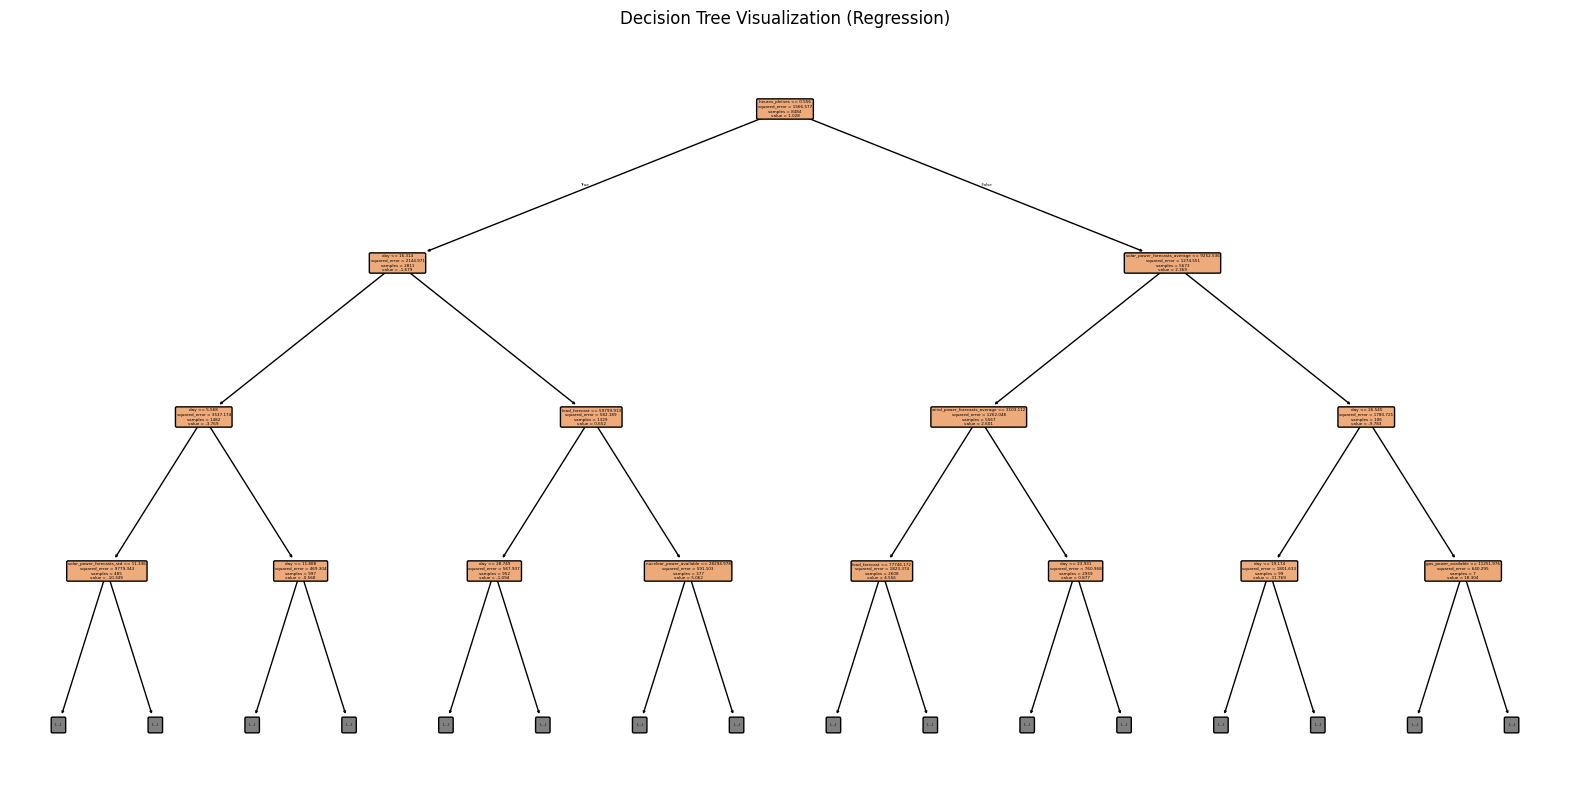

In [65]:
best_reg_model = grid_search_reg.best_estimator_

plt.figure(figsize=(20, 10))
plot_tree(
    best_reg_model,
    feature_names=X_train_reg.columns,
    filled=True,
    rounded=True,
    max_depth=3
)
plt.title("Decision Tree Visualization (Regression)")
plt.show()

In [66]:
# Evaluate regression model with weighted accuracy
y_pred_reg = best_reg_model.predict(X_test_reg)
wa_score_reg = weighted_accuracy(y_test_reg['spot_id_delta'], y_pred_reg)
print(f"✅ Weighted Accuracy (test set): {wa_score_reg:.4f}")

✅ Weighted Accuracy (test set): 0.8594


In [67]:
y_test_sign_reg = (y_test_reg['spot_id_delta'] > 0).astype(int)
y_pred_sign_reg = (y_pred_reg > 0).astype(int)
print("\nConfusion Matrix (Predicted vs Actual Signs):")
print(confusion_matrix(y_test_sign_reg, y_pred_sign_reg))
print("\nClassification Report:")
print(classification_report(y_test_sign_reg, y_pred_sign_reg))


Confusion Matrix (Predicted vs Actual Signs):
[[772 294]
 [233 822]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.72      0.75      1066
           1       0.74      0.78      0.76      1055

    accuracy                           0.75      2121
   macro avg       0.75      0.75      0.75      2121
weighted avg       0.75      0.75      0.75      2121



In [68]:
y_score_reg = y_pred_reg  # continuous output from regressor
y_test_bin_reg = label_binarize((y_test_sign_reg > 0).astype(int), classes=[0, 1])
auc_reg = roc_auc_score(y_test_bin_reg, y_score_reg)
print(f"🎯 AUC Score (positive sign): {auc_reg:.4f}")

🎯 AUC Score (positive sign): 0.8189


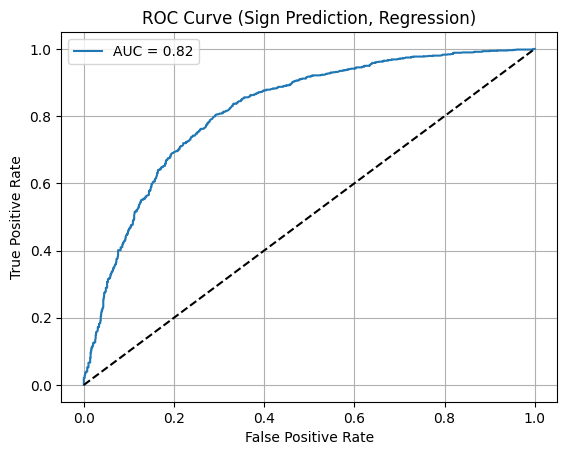

In [69]:
fpr_reg, tpr_reg, _ = roc_curve(y_test_bin_reg, y_score_reg)
plt.figure()
plt.plot(fpr_reg, tpr_reg, label=f"AUC = {auc_reg:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Sign Prediction, Regression)")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Predict on the test set and export results (regression)
X_test_spot = extract_datetime_features(X_test_spot, datetime_col="DELIVERY_START")
y_pred_reg_CV = best_reg_model.predict(X_test_spot)
y_output_reg_CV = y_random.copy()
y_output_reg_CV['spot_id_delta'] = y_pred_reg_CV
y_output_reg_CV.head()
y_output_reg_CV.to_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\output\y_output_reg_CV.csv", index=False)

# <p style="text-align:center;">Classifier CART</p>
In this section, we use a Decision Tree Classifier to predict the direction (sign) of the price difference. The model is trained to output -1 or 1, corresponding to a negative or positive price difference, respectively. We optimize the classifier using grid search and evaluate its performance with the custom weighted accuracy metric.

In [13]:
# Prepare binary labels: -1 for negative, 1 for positive price difference
y_binary = np.where(y_train['spot_id_delta'] > 0, 1, -1)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_train, y_binary, test_size=0.2, random_state=1)
X_train_clf = X_train_clf.drop("predicted_spot_price", axis=1)
X_test_clf = X_test_clf.drop("predicted_spot_price", axis=1)
X_test_spot_clf = X_test.copy()
X_test_spot_clf = X_test_spot_clf.drop("predicted_spot_price", axis=1)

In [14]:
# Grid search for best hyperparameters (classification)
clf = DecisionTreeClassifier(random_state=1)

param_grid_clf = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # log_loss = for probabilistic classification
    'splitter': ['best', 'random'],
    'max_depth': [None, 3, 5, 7, 10, 15, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [10, 20, 100, 200],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05],
    'class_weight': [None, 'balanced'],
    'ccp_alpha': [0.0, 0.01, 0.02, 0.05, 0.1],  # Post-pruning (since sklearn 0.22+)
}

grid_search_clf = GridSearchCV(clf, param_grid_clf, cv=5, scoring=weighted_accuracy_scorer, n_jobs=-1, verbose=1)

In [15]:
print(y_train_clf)

[ 1  1 -1 ... -1 -1  1]


In [16]:
grid_search_clf.fit(X_train_clf, y_train_clf)

# Display the best parameters found
print("Best parameters:", grid_search_clf.best_params_)
print("Best CV weighted accuracy:", grid_search_clf.best_score_)
print("\nTop 10 hyperparameter sets (by mean test score):")
results_clf = pd.DataFrame(grid_search_clf.cv_results_).sort_values('mean_test_score', ascending=False)
results_clf[['params', 'mean_test_score']].head(10)

Fitting 5 folds for each of 486000 candidates, totalling 2430000 fits
Best parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
Best CV weighted accuracy: 0.6384953747456665

Top 10 hyperparameter sets (by mean test score):


,params,mean_test_score
79206,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495
95412,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495
95418,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495
81006,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495
81012,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495
81018,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495
95406,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495
79200,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495
95400,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495
79212,"{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}",0.638495


In [17]:
best_clf = grid_search_clf.best_estimator_
print("🌟 Best hyperparameters:", grid_search_clf.best_params_)
print("✅ Best weighted accuracy (cross-validation):", grid_search_clf.best_score_)

# Display the top 10 hyperparameter sets from the grid search (sorted by mean test score)
results = pd.DataFrame(grid_search_clf.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print("\nTop 10 hyperparameter sets:")
print(results_sorted[['mean_test_score', 'params']].head(10).to_string(index=False))

🌟 Best hyperparameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
✅ Best weighted accuracy (cross-validation): 0.6384953747456665

Top 10 hyperparameter sets:
 mean_test_score                                                                                                                                                                                                                                         params
        0.638495     {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 50, 'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
        0.638495   {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 50, 'max_features': None, 'max

C:\Users\arman\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


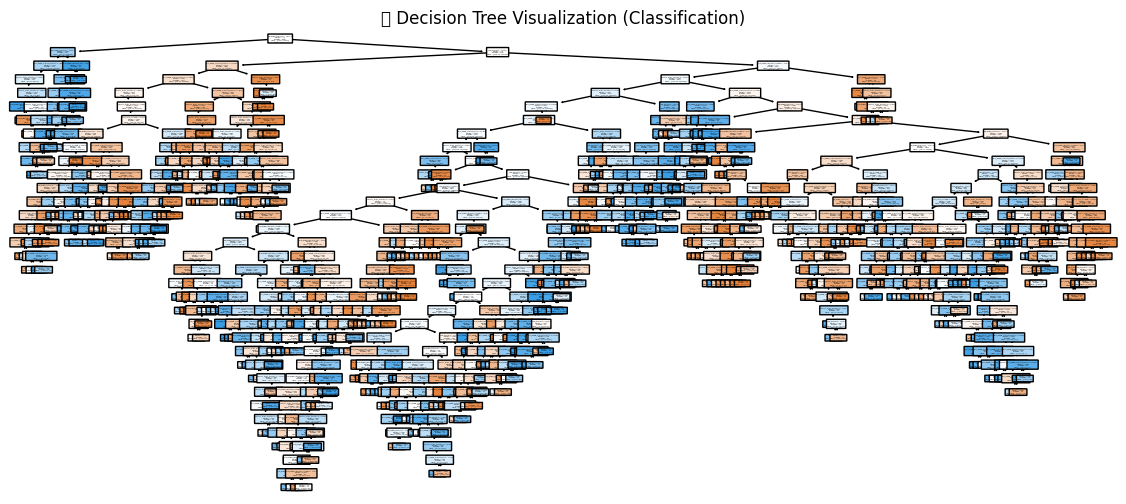

In [18]:
plt.figure(figsize=(14, 6))
plot_tree(best_clf,
          feature_names=X_train_clf.columns,
          class_names=['Spot <= ID', 'ID > Spot'],
          filled=True,
          rounded=True)
plt.title("🌳 Decision Tree Visualization (Classification)")
plt.show()

In [19]:
# Predict probabilities and labels for the test set (classification, -1/1 labels)
y_test_sign_clf = y_test_clf  # already -1 or 1
proba_index = list(best_clf.classes_).index(1)
y_pred_proba_clf = best_clf.predict_proba(X_test_clf)[:, proba_index]
y_pred_label_clf = np.where(y_pred_proba_clf > 0.5, 1, -1)

In [20]:
print("\n📊 Confusion Matrix:")
print(confusion_matrix(y_test_sign_clf, y_pred_label_clf))

print("\n📋 Classification Report:")
print(classification_report(y_test_sign_clf, y_pred_label_clf))

wa_score_clf = weighted_accuracy(y_test_sign_clf, y_pred_label_clf)
print(f"🎯 Weighted Accuracy: {wa_score_clf:.4f}")

auc_score_clf = roc_auc_score(y_test_sign_clf, y_pred_proba_clf)
print(f"📈 AUC Score: {auc_score_clf:.4f}")


📊 Confusion Matrix:
[[703 363]
 [366 689]]

📋 Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.66      0.66      1066
           1       0.65      0.65      0.65      1055

    accuracy                           0.66      2121
   macro avg       0.66      0.66      0.66      2121
weighted avg       0.66      0.66      0.66      2121

🎯 Weighted Accuracy: 0.6563
📈 AUC Score: 0.7094


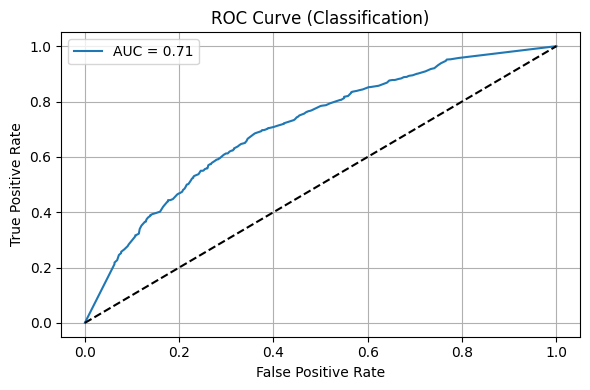

In [21]:
fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test_sign_clf, y_pred_proba_clf)
plt.figure(figsize=(6, 4))
plt.plot(fpr_clf, tpr_clf, label=f"AUC = {auc_score_clf:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Classification)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
# Predict on the test set and export results (classification)
y_pred_class_CV = best_clf.predict(X_test_spot_clf)
y_output_class_CV = y_random.copy()
y_output_class_CV['spot_id_delta'] = y_pred_class_CV
y_output_class_CV.head()
y_output_class_CV.to_csv(r"C:\Users\arman\Desktop\Power_Spot_Price_Forecasting\output\y_output_class_CV.csv", index=False)